In [1]:
import sys
import glob
import re
import fnmatch
import math
import os
from os import listdir
from os.path import join, isfile, basename

import itertools

import numpy as np
from numpy import float32, int32, uint8, dtype, genfromtxt

from scipy.stats import ttest_ind

import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import colorsys

In [2]:
# VFB labels and label names
labels = [16,64,8,32,2,4,65,66,33,67,34,17,69,70,35,71,9,18,72,36,73,74,37,75,19,76,38,77,39,78,79,20,5,40,80,10,81,82,83,84,85,86,11,22,23,24,12,3,6,49,50,25,51,13,52,26,53,27,54,55,56,28,7,14,57,58,29,59,30,60,15,61,31,62,63]
label_names_file = '/groups/saalfeld/home/bogovicj/vfb/DrosAdultBRAINdomains/refData/Original_Index.tsv'

label_names = pd.read_csv( label_names_file, delimiter='\t', header=0 )
# print label_names[ label_names['Stack id'] == 11 ]['JFRCtempate2010.mask130819' ].iloc[0]
# print label_names[ label_names['Stack id'] == 70 ]['JFRCtempate2010.mask130819' ].iloc[0]

def get_label_name( label_id ):
    return label_names[ label_names['Stack id'] == label_id ]['JFRCtempate2010.mask130819' ].iloc[0]

 # label_names['JFRCtempate2010.mask130819']

label_shorthand_col ='JFRCtempate2010.mask130819'
label_id_col ='Stack id'


# Find left-right matching labels
rnames = label_names[ label_names.apply( lambda x : x[label_shorthand_col].endswith('_R'), axis=1 )]

lr_pair_list = []
for rn in rnames.loc[:,label_shorthand_col]:
    ln = rn.replace('_R','_L')
    id_R = label_names[ label_names[label_shorthand_col]==rn ].loc[:,label_id_col]
    id_L = label_names[ label_names[label_shorthand_col]==ln ].loc[:,label_id_col]
    lr_pair_list += [[id_R.values[0], id_L.values[0]]]
lr_pair_list = np.array( lr_pair_list )

In [3]:
path='/nrs/saalfeld/john/projects/flyChemStainAtlas/all_evals/F-antsFlip/cmtkCow/evalComp/stats0.txt'

def readlines( f ):
    f = open( f, 'r' )
    lines = f.readlines()
    f.close()
    return lines

def labelstat( lines, label, stat='MEDIAN'):
    statupper = stat.upper()
    for l in lines:
        if l.startswith(str(label)):
            if l.find(statupper) >= 0:
                return float( l.split()[2] )


In [6]:
base_dir = '/nrs/saalfeld/john/projects/flyChemStainAtlas/all_evals'

# templates = ['JFRCtemplate2010']
# reg_methods = [ 'cmtkCow', 'cmtkCOG', 'antsRegYang' ]

templates = ['JFRCtemplate2010', 'JFRC2013_lo', 'F-antsFlip_lo', 'F-cmtkFlip_lof', 'TeforBrain_f']
# reg_methods = [ 'cmtkCow', 'cmtkCOG', 'cmtkHideo' ]
# reg_methods = [ 'antsRegOwl', 'antsRegDog', 'antsRegYang' ]
reg_methods = [ 'cmtkCow', 'cmtkCOG', 'cmtkHideo', 'antsRegOwl', 'antsRegDog', 'antsRegYang' ]


In [7]:
# parse all data into a data frame

expnamelist=[]
algnamelist=[]
templatelist=[]
statlist=[]
datalist=[]
labellist=[]
labelnamelist=[]
linelist=[]
linelabellist=[]

for template,reg in itertools.product( templates, reg_methods ):

    exp_dir = join( base_dir, template, reg )
#     print exp_dir
    name_f = join(exp_dir,'name')
    if os.path.isfile( name_f ):
        expname = readlines( join(exp_dir,'name'))[0]
    else:
        expname = '{},{}'.format(template,reg)

#     print expname 
    for line in [0,1,2,3]:
        eval_dir=join(exp_dir,'evalComp')
#         print eval_dir
        # Read label stats
        statFile = '{}/stats{}.txt'.format(eval_dir,line)
        stat_lines = readlines( statFile )
        for sl in stat_lines:
            dat = sl.split()
            label = int(dat[0])
            line_label = str(line) + '_' + str(label)
           
            expnamelist += [ expname.replace('\n','') ]
            algnamelist += [ reg ]
            templatelist += [ template ]
            linelist += [ line ]
            labellist += [ label ]
            linelabellist += [ line_label ]
            labelnamelist += [ get_label_name(label) ]
            statlist += [ dat[1] ]
            datalist += [ float(dat[2]) ]
            
        # Read total brain mask stats
        allStatFile = '{}/all_stats{}.txt'.format(eval_dir,line)
        all_stat_lines = readlines( allStatFile )
        label = -1
        for sl in all_stat_lines:
            if( sl.startswith('all ')):
                line_label = str(line) + '_' + str(label)
                dat = sl.split()
                expnamelist += [ expname.replace('\n','') ]
                algnamelist += [ reg ]
                templatelist += [ template ]
                linelist += [ line ]
                labellist += [ label ] # -1 indicates total mask label
                linelabellist += [ line_label ]
                labelnamelist += [ 'ALL' ]
                statlist += [ dat[1] ]
                datalist += [ float(dat[2]) ]


dist_df = pd.DataFrame( {'EXP':expnamelist, 
                         'ALG':algnamelist, 
                         'TEMPLATE':templatelist, 
                         'STAT':statlist,
                         'LINE':linelist,
                         'LABEL':labellist,
                         'LINELABEL':linelabellist,
                         'LABELNAME':labelnamelist,
                         'VALUE':datalist })

## Determine the best algorithm

Below is average over median and mean distances per line-label, though it may be worth it to also
filter by "useful" line-labels, but this should not matter.

In [10]:
# Group by algorithm, then average over mean distances
avg_avg_dists = dist_df.loc[(dist_df.STAT == 'MEAN'),['ALG','VALUE']].groupby(['ALG'],as_index=False).mean()
aads = avg_avg_dists.sort_values('VALUE', ascending=True)
print( 'best by avg_avg is: ',aads.iloc[0]['ALG'])


# Group by algorithm, then average over median distances
avg_med_dists = dist_df.loc[(dist_df.STAT == 'MEDIAN'),['ALG','VALUE']].groupby(['ALG'],as_index=False).mean()
amds = avg_med_dists.sort_values('VALUE', ascending=True)
print( 'best by avg_med is: ', amds.iloc[0]['ALG'])

print( ' ' )
print( ' ' )
print( aads )
print( ' ' )
print ( ' ' )
print( amds )

best by avg_avg is:  cmtkCOG
best by avg_med is:  cmtkCOG
 
 
           ALG     VALUE
3      cmtkCOG  6.565228
5    cmtkHideo  6.602061
0   antsRegDog  6.733418
1   antsRegOwl  6.806076
4      cmtkCow  6.846528
2  antsRegYang  6.980998
 
 
           ALG     VALUE
3      cmtkCOG  5.320492
5    cmtkHideo  5.379651
0   antsRegDog  5.499060
4      cmtkCow  5.695244
1   antsRegOwl  5.711444
2  antsRegYang  5.896575


## Significance tests
and other tests

In [11]:
# Load combined data
dist_samples_f = '/nrs/saalfeld/john/projects/flyChemStainAtlas/all_evals/label_data.csv.gz'
dist_samples_df = pd.read_csv( dist_samples_f, header=None, names=['TEMPLATE','ALG','LINE','LABEL','DISTANCE'] )



In [12]:
dist_0_70 = dist_samples_df[ ((dist_samples_df.ALG == 'cmtkCOG') | (dist_samples_df.ALG == 'antsRegDog')) & 
               (dist_samples_df.LINE == 0) & (dist_samples_df.LABEL == 70)]

In [13]:
# dist_0_70.sample(500)
print( dist_0_70.shape )
dist_0_70_fantsgrp = dist_0_70[(dist_0_70.TEMPLATE == 'F-antsFlip_lo')]
print( dist_0_70_fantsgrp.shape )

(15165270, 5)
(3141130, 5)


In [14]:

d_cog = dist_0_70_fantsgrp[ dist_0_70_fantsgrp.ALG == 'cmtkCOG']
print( d_cog.shape )

d_yang = dist_0_70_fantsgrp[ dist_0_70_fantsgrp.ALG == 'antsRegDog']
print( d_yang.shape )

t,p = ttest_ind( d_cog['DISTANCE'], d_yang['DISTANCE'])
print( 't:', t )
print( 'p:', p )

(1584440, 5)
(1556690, 5)
t: 4.56048161292
p: 5.10383544402e-06


In [16]:
print( 'cog: ', d_cog.median())
print( 'dog: ', d_yang.median())

cog:  LINE         0.000000
LABEL       70.000000
DISTANCE     2.915476
dtype: float64
dog:  LINE         0.000000
LABEL       70.000000
DISTANCE     2.915476
dtype: float64


In [17]:
print( 'cog: ', d_cog.DISTANCE.mean())
print( 'dog: ', d_yang.DISTANCE.mean())

cog:  3.19841645534
dog:  3.18909376434


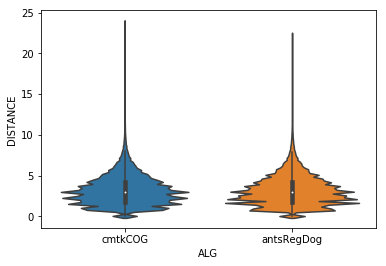

In [18]:
d_cog_yang = dist_0_70_fantsgrp[ (dist_0_70_fantsgrp.ALG == 'cmtkCOG') | (dist_0_70_fantsgrp.ALG == 'antsRegDog') ]
sns.violinplot( y=d_cog_yang.DISTANCE, x=d_cog_yang.ALG )

## Determine the best template (using the best algorithm)

In [23]:
# Statistics for the best algorithm
best_alg_dists = dist_df[dist_df.ALG == 'cmtkCOG']


best_alg_avg_avg_dists = dist_df.loc[(dist_df.STAT == 'MEAN'),['TEMPLATE','VALUE']].groupby(['TEMPLATE'],as_index=False).mean()
sorted_best_by_avg = best_alg_avg_avg_dists.sort_values('VALUE', ascending=True)
print( 'best by avg_avg is: ', sorted_best_by_avg.iloc[0]['TEMPLATE'])
print(' ')
print('ordering:')
print(sorted_best_by_avg)
print(' ')
print(' ')

best_alg_avg_med_dists = dist_df.loc[(dist_df.STAT == 'MEDIAN'),['TEMPLATE','VALUE']].groupby(['TEMPLATE'],as_index=False).mean()
sorted_best_by_med = best_alg_avg_med_dists.sort_values('VALUE', ascending=True)
print( 'best by avg_med is: ', sorted_best_by_med.iloc[0]['TEMPLATE'] )
print(' ')
print('ordering:')
print(sorted_best_by_med)

best by avg_avg is:  F-antsFlip_lo
 
ordering:
           TEMPLATE     VALUE
0     F-antsFlip_lo  6.268178
1    F-cmtkFlip_lof  6.518722
2       JFRC2013_lo  6.863953
4      TeforBrain_f  6.918917
3  JFRCtemplate2010  7.207540
 
 
best by avg_med is:  F-antsFlip_lo
 
ordering:
           TEMPLATE     VALUE
0     F-antsFlip_lo  5.132273
1    F-cmtkFlip_lof  5.320864
4      TeforBrain_f  5.706866
2       JFRC2013_lo  5.769926
3  JFRCtemplate2010  5.987649


## Determining the line-labels with the most sample

In [24]:
dist_by_linelabel = (dist_df.loc[ (dist_df.LABEL > 0) & (dist_df.STAT == 'COUNT'), ['LINELABEL','VALUE'] ]).sort_values('VALUE', ascending=False)
# dist_by_linelabel.tail(50)

## Cluster line-labels

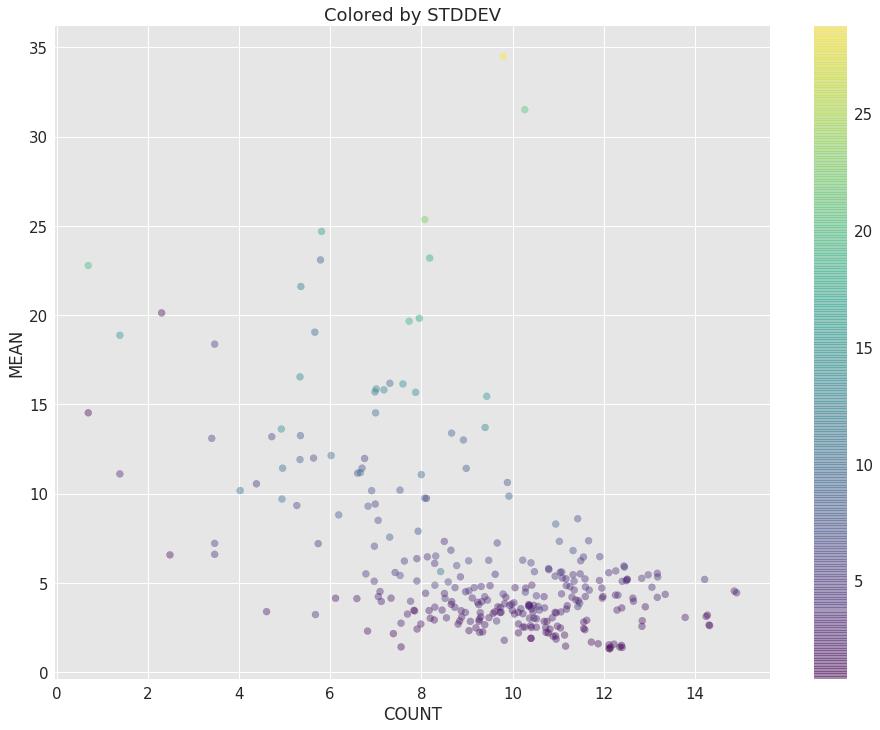

In [25]:
# get line-label wise statistics for the best algorithm and template
best_exp_df = dist_df[ (dist_df.ALG == 'cmtkCOG') & (dist_df.TEMPLATE == 'F-antsFlip_lo') & (dist_df.LABEL > 0 )]

# Reorganize
best_exp_df_4cluster = best_exp_df.pivot(index='LINELABEL', columns='STAT', values='VALUE')
# print( best_exp_df_4cluster.head() )

log_counts = best_exp_df_4cluster.COUNT.map( lambda x: math.log(x))

# sns.kdeplot( best_exp_df_4cluster.MEAN, best_exp_df_4cluster.STDDEV )

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# points = plt.scatter( best_exp_df_4cluster['MEAN'],  best_exp_df_4cluster['STDDEV'],
#            c=log_counts, alpha=0.4, cmap="viridis")
points = plt.scatter( log_counts, best_exp_df_4cluster['MEAN'], 
           c=best_exp_df_4cluster['STDDEV'], alpha=0.4, cmap="viridis")
plt.xlabel('COUNT')
plt.ylabel('MEAN')
plt.title('Colored by STDDEV')
plt.colorbar( points )

fig = plt.gcf()
a = fig.set_size_inches( 16, 12 )

The above isn't so clearly "clustered" to my eye, but I do wonder about those line-labels with very high mean distance

In [26]:
# What line-labels have such a high mean?

best_exp_df_4cluster[best_exp_df_4cluster.MEAN > 20 ]


STAT,COUNT,MAX,MEAN,MEDIAN,MIN,STDDEV
LINELABEL,,,,,,
1_4,326.0,39.648457,23.095683,21.942920,8.746428,8.313019
2_25,18024.0,96.044258,34.493334,21.696773,0.000000,28.713701
2_71,28792.0,89.218834,31.513696,24.372116,0.000000,20.716863
3_22,3214.0,80.541916,25.355005,14.662878,0.000000,22.657337
3_24,212.0,50.690235,21.606401,19.176799,1.581139,11.460998
3_35,10.0,21.610184,20.124840,20.309914,18.234583,1.044434
3_69,3578.0,82.416626,23.197841,20.772564,0.000000,17.468560
3_75,334.0,68.996376,24.691066,21.103878,3.000000,16.330725
3_8,2.0,42.243343,22.779984,22.779984,3.316625,19.463359


Okay, so some of these have small or very small sample size, but what of the two with > 10k samples..?

In [54]:
# For each line, Sort labels by average size
gb_line_label = dist_df[ (dist_df.STAT == 'COUNT') ].groupby(['LINE','LABEL','LABELNAME','LINELABEL'], as_index=False )
line_label_avgs = gb_line_label.mean().sort_values('VALUE', ascending=False)

In [45]:
# Figure out colors
numTemplates = 4
numRegalgs = 6

plot_colors = []

for ti,ai in itertools.product( range(numTemplates), range(numRegalgs)):
#     print ti,ai
    plot_colors += [ colorsys.hsv_to_rgb( float(ti)/numTemplates, 0.25 + 0.75*float(ai)/numRegalgs, 1.0  )]


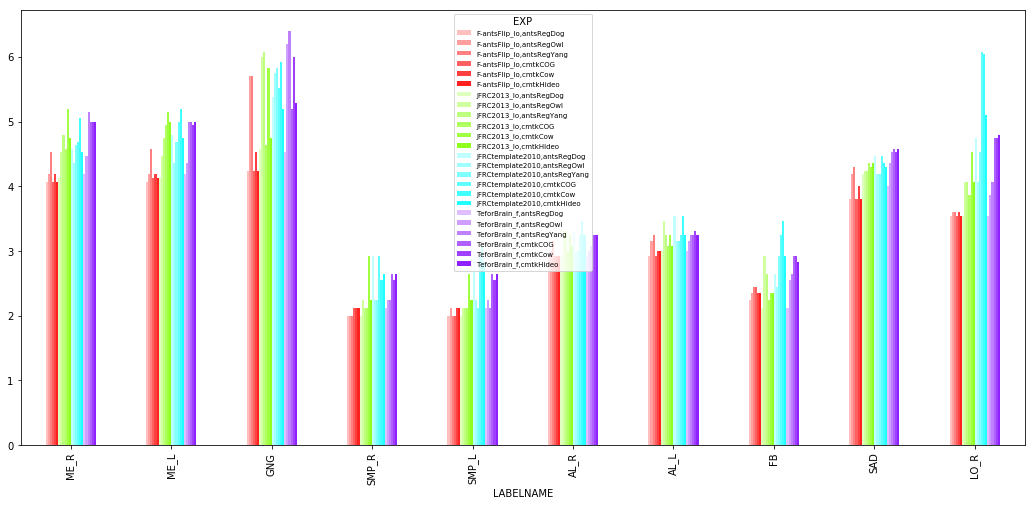

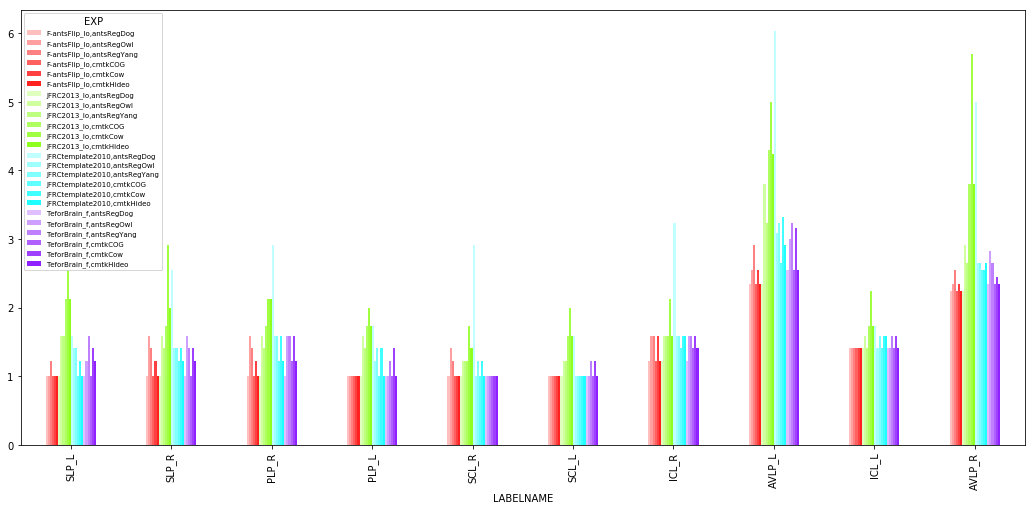

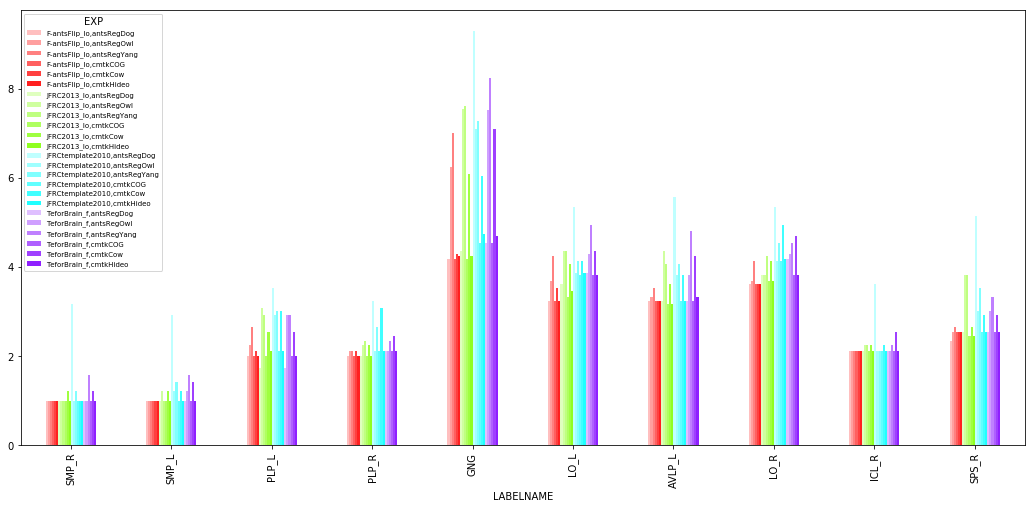

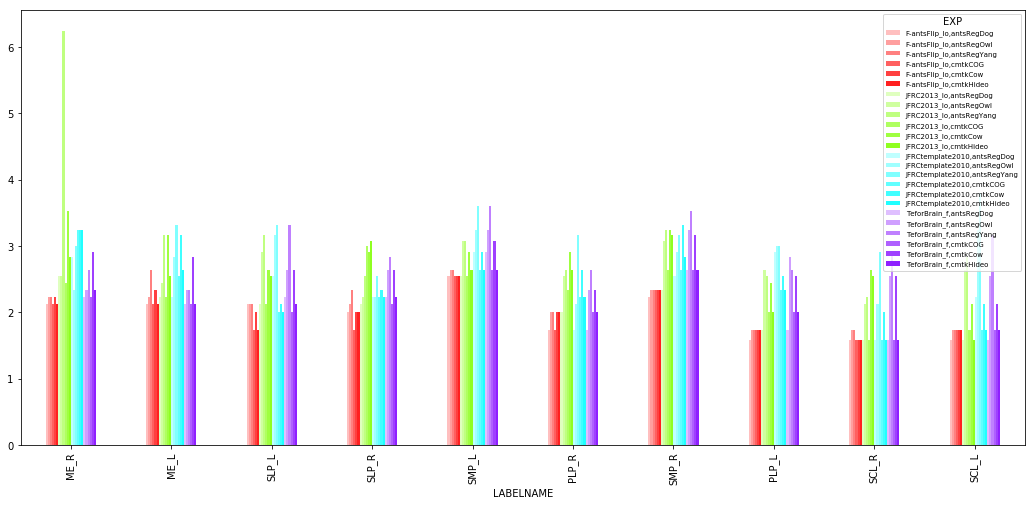

In [47]:
# For each line, plot the median distance over templates/regMethod

# Only plot for the top N labels
N = 10
line = 0

plt.rc('legend',fontsize=7) # using a size in points

for line in [0,1,2,3]:
    #     print line
    # Get the top N labels for this line
#     l = line_label_avgs[ (line_label_avgs.LINE == line ) & (line_label_avgs.LABEL > 0) ].head( N ).LABEL
    ln = line_label_avgs[ (line_label_avgs.LINE == line ) & (line_label_avgs.LABEL > 0) ].head( N ).LABELNAME
    med_df = dist_df[(dist_df.STAT == 'MEDIAN') & (dist_df.LINE == line) & (dist_df.LABEL > 0) ]
#     print med_df.head()
    
#     med_df_piv = med_df[['EXP','LABEL','VALUE']].pivot( index='LABEL', columns='EXP', values='VALUE' )
#     med_df_piv.loc[ l ].plot.bar( color=plot_colors )
    med_df_piv = med_df[['EXP','LABELNAME','VALUE']].pivot( index='LABELNAME', columns='EXP', values='VALUE' )
    med_df_piv.loc[ ln ].plot.bar( color=plot_colors )
    
    fig = plt.gcf()
    a = fig.set_size_inches( 18, 8 )

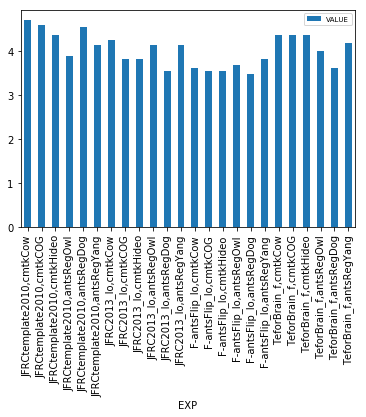

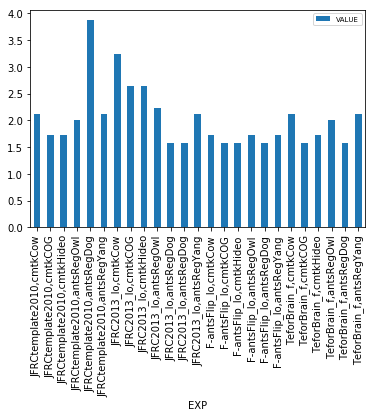

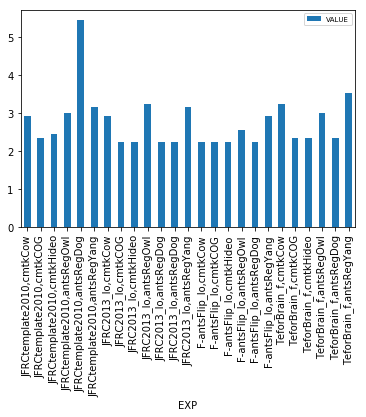

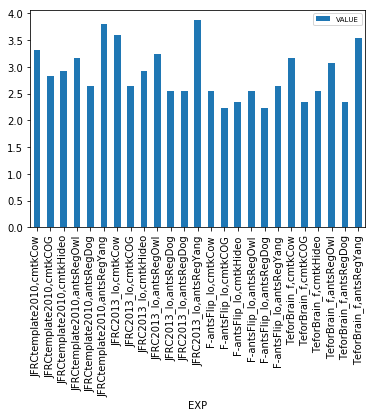

In [48]:
# For each line, plot the median distance over all labels for templates/regMethod 

for line in [0,1,2,3]:
    med_df = dist_df[(dist_df.STAT == 'MEDIAN') & (dist_df.LINE == line) & (dist_df.LABEL == -1)]
    med_df[['EXP','VALUE']].set_index('EXP').plot.bar()

In [112]:
#sz_templates = [ 'F-antsFlip', 'F-antsFlip_lo', 'F-antsFlip_1p52', 'F-antsFlip_2p4']
sz_templates = [  'F-antsFlip_2p4iso', 'F-antsFlip_1p2iso', 'F-antsFlip_lo', 'F-antsFlip' ]
sz_reg_methods = ['cmtkCOG']

exp_order = []

# parse all data into a data frame
expnamelist=[]
statlist=[]
datalist=[]
labellist=[]
linelist=[]

for template,reg in itertools.product( sz_templates, sz_reg_methods ):

    exp_dir = join( base_dir, template, reg )
#     print exp_dir
    name_f = join(exp_dir,'name')
    if os.path.isfile( name_f ):
        expname = readlines( join(exp_dir,'name'))[0].rstrip()
    else:
        expname = '{},{}'.format(template,reg)

    exp_order += [expname]
    
    for line in [0,1,2,3]:
        eval_dir=join(exp_dir,'evalComp')
        # Read label stats
        statFile = '{}/stats{}.txt'.format(eval_dir,line)
        stat_lines = readlines( statFile )
        for sl in stat_lines:
            dat = sl.split()
            expnamelist += [ expname.replace('\n','') ]
            linelist += [ line ]
            labellist += [ int(dat[0]) ]
            statlist += [ dat[1] ]
            datalist += [ float(dat[2]) ]
            
        # Read total brain mask stats
        allStatFile = '{}/all_stats{}.txt'.format(eval_dir,line)
        all_stat_lines = readlines( allStatFile )
        for sl in all_stat_lines:
            if( sl.startswith('all ')):
                dat = sl.split()
                expnamelist += [ expname.replace('\n','') ]
                linelist += [ line ]
                labellist += [ -1 ] # -1 indicates total mask label
                statlist += [ dat[1] ]
                datalist += [ float(dat[2]) ]


sz_dist_df = pd.DataFrame( {'EXP':expnamelist, 
                         'STAT':statlist,
                         'LINE':linelist,
                         'LABEL':labellist,
                         'VALUE':datalist })


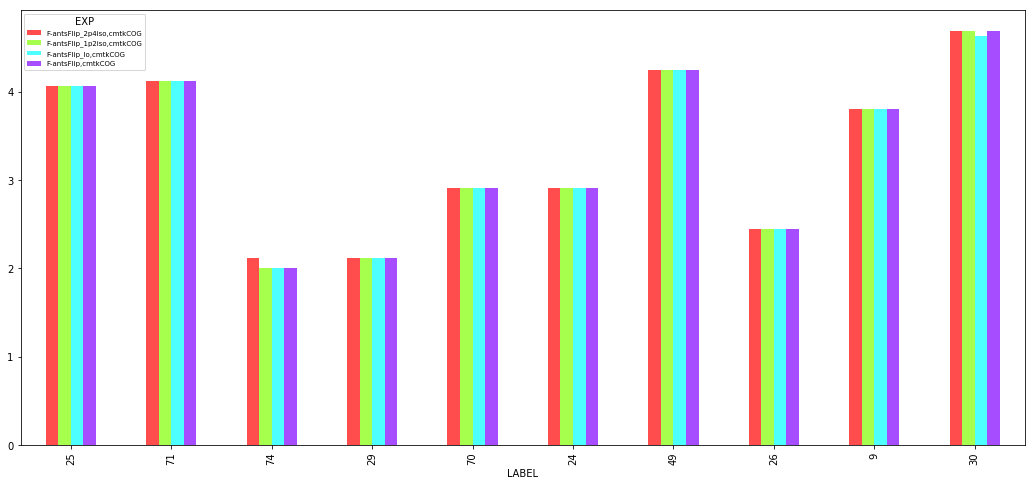

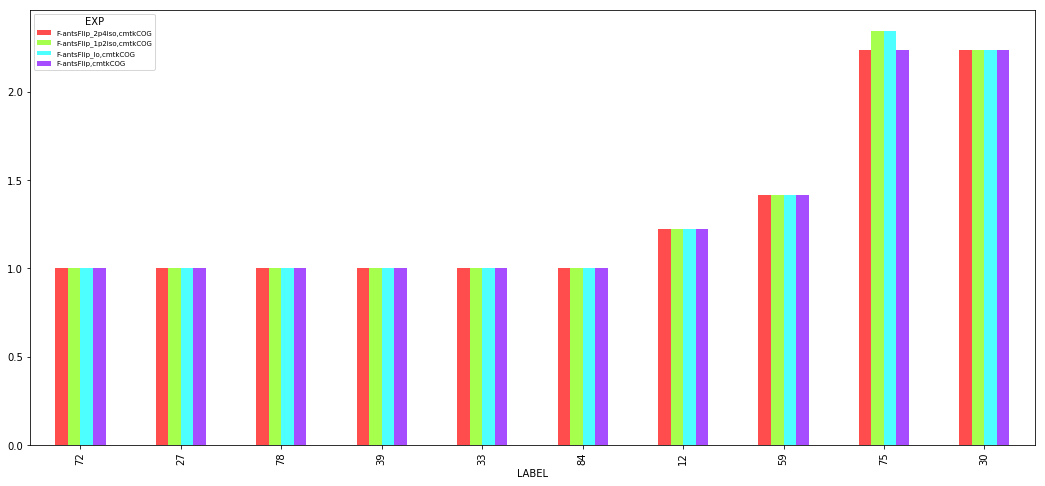

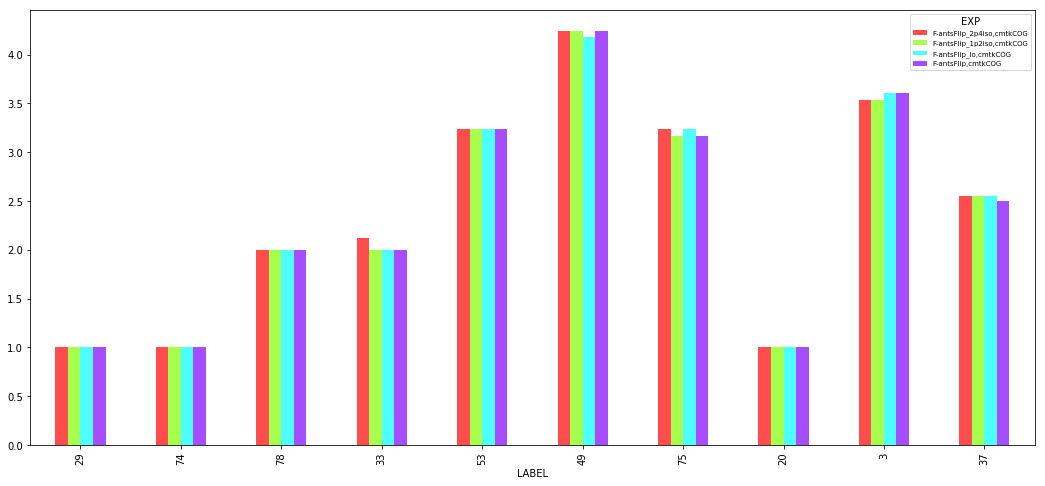

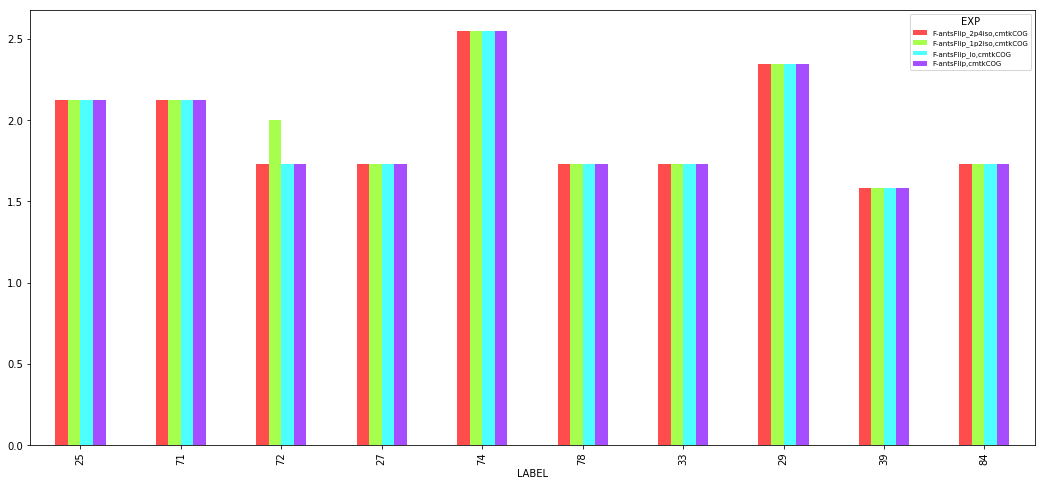

In [51]:
# For each line, Sort labels by average size
sz_gb_line_label = sz_dist_df[ (sz_dist_df.STAT == 'COUNT') ].groupby(['LINE','LABEL'], as_index=False )
sz_line_label_avgs = sz_gb_line_label.mean().sort_values('VALUE', ascending=False)

# Figure out colors
numTemplates = len(exp_order)
numRegalgs = 1

plot_colors = []

for ti,ai in itertools.product( range(numTemplates), range(numRegalgs)):
#     print ti,ai
    plot_colors += [ colorsys.hsv_to_rgb( float(ti)/numTemplates, 0.7 + float(ai)/numRegalgs, 1.0  )]


# For each line, plot the median distance over templates/regMethod
# Only plot for the top N labels
N = 10
line = 0

plt.rc('legend',fontsize=7) # using a size in points

for line in [0,1,2,3]:
    #     print line
    # Get the top N labels for this line
    l = sz_line_label_avgs[ (sz_line_label_avgs.LINE == line ) & (sz_line_label_avgs.LABEL > 0) ].head( N ).LABEL
    med_df = sz_dist_df[(sz_dist_df.STAT == 'MEDIAN') & (sz_dist_df.LINE == line) & (sz_dist_df.LABEL > 0) ]
    med_df_piv = med_df[['EXP','LABEL','VALUE']].pivot( index='LABEL', columns='EXP', values='VALUE' )
    med_df_piv[exp_order].loc[ l ].plot.bar( color=plot_colors )
    
    fig = plt.gcf()
    a = fig.set_size_inches( 18, 8 )